<a href="https://colab.research.google.com/github/abhigoogol/Autoencoders-using-Pytorch/blob/master/02_Autoencoder_Classifier_Layer_Wise_Pre_training_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy

plt.style.use('default')

In [0]:
transform = transforms.ToTensor()

traindataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
testdataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

0it [00:00, ?it/s]

26427392it [00:04, 5643094.71it/s]                              


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 36301.90it/s]                           
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:02, 1641760.29it/s]                            
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 13633.39it/s]            

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
bs = 1000

In [0]:
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

In [0]:
print(trainloader.dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: .
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [0]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 100),
        nn.ReLU())
    self.decoder = nn.Sequential(
        nn.Linear(100, 28*28),
        nn.ReLU())
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [0]:
net = AutoEncoder()
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)

In [0]:
if torch.cuda.is_available():
  GPU = 1
  print('Training on GPU')
  net = net.cuda()

Training on GPU


In [0]:
init_weights = copy.deepcopy(net.encoder[0].weight.data)

In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [0]:
epochs = 10
for epoch in range(epochs):
  runningloss = 0
  
  for images, labels in trainloader:
    if GPU:
       
      images, labels = Variable(images.view(images.size()[0], -1)).cuda(), Variable(labels).cuda()
    
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, images.view(images.size()[0], -1))
    loss.backward()
    optimizer.step()
    runningloss += loss.item()/images.shape[0]
  print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

Epoch: 1/10 	 Mean Square Error Loss: 0.006218520961701869
Epoch: 2/10 	 Mean Square Error Loss: 0.003681280668824911
Epoch: 3/10 	 Mean Square Error Loss: 0.0030497065111994735
Epoch: 4/10 	 Mean Square Error Loss: 0.0027333141416311267
Epoch: 5/10 	 Mean Square Error Loss: 0.0025247507728636265
Epoch: 6/10 	 Mean Square Error Loss: 0.002415501683950424
Epoch: 7/10 	 Mean Square Error Loss: 0.002340568799525499
Epoch: 8/10 	 Mean Square Error Loss: 0.002287952423095704
Epoch: 9/10 	 Mean Square Error Loss: 0.00222288578003645
Epoch: 10/10 	 Mean Square Error Loss: 0.0021493490636348726


# Testing Autoencoder Performance

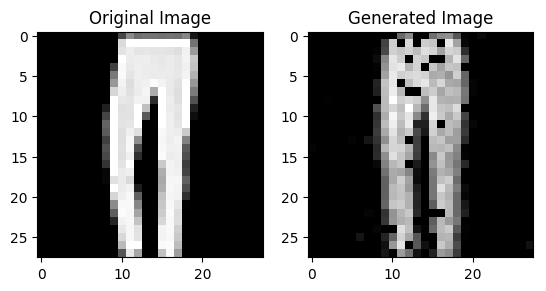

In [0]:
test_images, labels = next(iter(testloader))

if GPU:
  test_images = Variable(images.view(images.size()[0], -1)).cuda()
  test_output = net(test_images)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(out[0].cpu().detach(), cmap='gray')
plt.show()

# Encode Weights Visualization

In [0]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

d_weights = init_weights - trained_weights

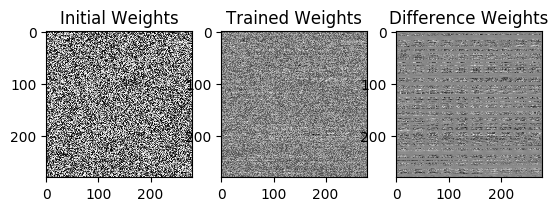

In [0]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(init_weights.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(trained_weights.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1,280,280).cpu()[0], cmap='gray')

#  Adding more layers

In [0]:
net.encoder.add_module('layer', nn.Sequential(nn.Linear(100, 100), nn.ReLU()))
net.decoder = nn.Sequential(nn.Linear(100, 100), nn.ReLU(), net.decoder)
print(net)
if GPU:
  net = net.cuda()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (layer): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=100, out_features=784, bias=True)
      (1): ReLU()
    )
  )
)


In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [0]:
epochs = 10
for epoch in range(epochs):
  runningloss = 0
  
  for images, labels in trainloader:
    if GPU:
       
      images, labels = Variable(images.view(images.size()[0], -1)).cuda(), Variable(labels).cuda()
    
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, images.view(images.size()[0], -1))
    loss.backward()
    optimizer.step()
    runningloss += loss.item()/images.shape[0]
  print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

Epoch: 1/10 	 Mean Square Error Loss: 0.004525984942913055
Epoch: 2/10 	 Mean Square Error Loss: 0.002568145625293255
Epoch: 3/10 	 Mean Square Error Loss: 0.002251899760216475
Epoch: 4/10 	 Mean Square Error Loss: 0.0021049459800124163
Epoch: 5/10 	 Mean Square Error Loss: 0.001978558272123337
Epoch: 6/10 	 Mean Square Error Loss: 0.001898935774341225
Epoch: 7/10 	 Mean Square Error Loss: 0.0018607930894941093
Epoch: 8/10 	 Mean Square Error Loss: 0.0018257617074996233
Epoch: 9/10 	 Mean Square Error Loss: 0.0017896025292575349
Epoch: 10/10 	 Mean Square Error Loss: 0.001751139115542173


# Testing Autoencoder Performance

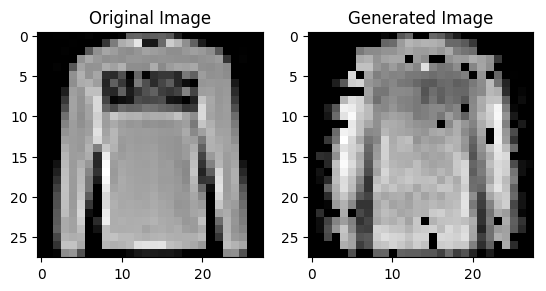

In [0]:
test_images, labels = next(iter(testloader))

if GPU:
  test_images = Variable(images.view(images.size()[0], -1)).cuda()
  test_output = net(test_images)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(out[0].cpu().detach(), cmap='gray')
plt.show()

# Remove decoder and add classification layer

In [0]:
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (layer): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=100, out_features=784, bias=True)
      (1): ReLU()
    )
  )
)

In [0]:
new_classif = nn.Sequential(*list(net.children())[:-1])
net = new_classif
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10), nn.LogSoftmax(dim=1)))
print(net)

if GPU:
  net = net.cuda()
  
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (layer): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [0]:
epochs = 20
for epoch in range(epochs):
  runningloss = 0
  
  for images, labels in trainloader:
    if GPU:
      images, labels = Variable(images.view(images.size()[0], -1)).cuda(), Variable(labels).cuda()
#     print(images.shape, labels.shape)
    output = net(images)
    optimizer.zero_grad()
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    runningloss += loss.item()/images.shape[0]
  
  else:
    net.eval()
    total_correct = 0
    with torch.no_grad():
      for images, labels in testloader:
        if GPU:
          images, labels = Variable(images.view(images.size()[0], -1)).cuda(), Variable(labels).cuda()
          output_acc = net(images)
          _, pred = torch.max(output_acc, 1)
          total_correct += torch.sum(pred==labels).item()
    accuracy = total_correct / len(testloader.dataset)
  print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch+1, epochs, runningloss, accuracy))

Epoch: 1/20 	 Training Loss: 0.07555235636234284, Test Accuracy: 0.6834
Epoch: 2/20 	 Training Loss: 0.04335275483131407, Test Accuracy: 0.7516
Epoch: 3/20 	 Training Loss: 0.03798016405105592, Test Accuracy: 0.7801
Epoch: 4/20 	 Training Loss: 0.03480267870426178, Test Accuracy: 0.7964
Epoch: 5/20 	 Training Loss: 0.032730620831251146, Test Accuracy: 0.8085
Epoch: 6/20 	 Training Loss: 0.031185381054878232, Test Accuracy: 0.8128
Epoch: 7/20 	 Training Loss: 0.03000062289834022, Test Accuracy: 0.8178
Epoch: 8/20 	 Training Loss: 0.029280507832765576, Test Accuracy: 0.8238
Epoch: 9/20 	 Training Loss: 0.028675435870885845, Test Accuracy: 0.822
Epoch: 10/20 	 Training Loss: 0.02779119005799293, Test Accuracy: 0.8246
Epoch: 11/20 	 Training Loss: 0.02741146215796471, Test Accuracy: 0.8283
Epoch: 12/20 	 Training Loss: 0.02695059490203857, Test Accuracy: 0.8319
Epoch: 13/20 	 Training Loss: 0.0266017206609249, Test Accuracy: 0.8328
Epoch: 14/20 	 Training Loss: 0.02612622791528702, Test Ac

# Encoder Weights Visualization

In [0]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

d_weights = cll_weights - cll_weights_ft

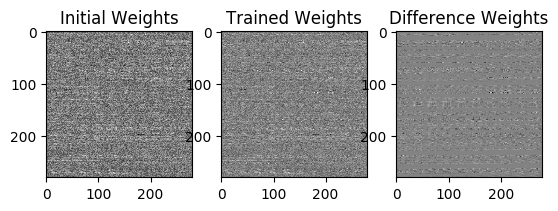

In [0]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(cll_weights.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(cll_weights_ft.view(-1,280,280).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1,280,280).cpu()[0], cmap='gray')

# Classifier Weights Visualization

In [0]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

d_weights = init_classifier_weights - trained_classifier_weights

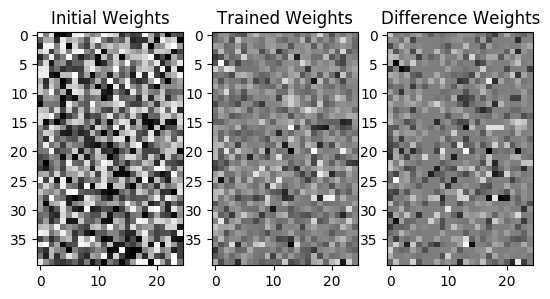

In [0]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(init_classifier_weights.view(-1, 40, 25).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(trained_classifier_weights.view(-1,40, 25).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1,40, 25).cpu()[0], cmap='gray')